In [3]:
# faire une première partie sur la combinatoire, en faisant le truc un peu bien.
# todo : corriger la prise en compte du max. Aujourd'hui, c'est le max de chaque pool qui est pris en compte dans le score
# au lieu du max de tout
# todo : idem au point précédent, vérifier si l'écart type est bien pris en compte
# todo : mesurer un temps acceptable dans le parcours brutal, et ajouter un print à la fin du run pour dire combien de 
# combinaisons ont été explorées
# todo : faire une fonctionnalité qui permet de sauvegarder dans un fichier les différents run faits, avec paramètres,
# coordonnées et résultats
# todo : commencer à regarder un algo plus greedy, d'abord un qui échange les villes dès que c'est positif, et l'autre qui 
# échange sur le gain maximum
# todo : traiter le cas où on n'a pas forcément des pools de la même taille


# Gestion des imports

In [29]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from itertools import combinations
from itertools import cycle
from copy import deepcopy
from collections import defaultdict
from math import factorial


# Analyse de la combinatoire
## Cas de la factorielle

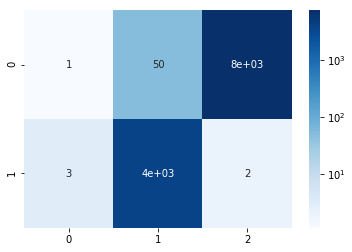

In [32]:
sns.heatmap([[1, 50, 8000], [3, 4000, 2]], 
            annot=True, 
            robust=True, 
            cmap='Blues', 
            cbar_kws={"ticks":[0,1,10,1e2,1e3,1e4,1e5]},
            norm=LogNorm(0,8000))

In [5]:
# paramètres du problème
pool_count = 3
pools = {i:set() for i in range(1, pool_count+1)}
cities = {
    0: 'Paris',
    1: 'Montpellier',
    2: 'Marseille',
    3: 'Fontenay aux Roses',
    4: 'Antony',
    5: 'Saint Denis',
    6: 'Sceaux',
    7: 'Chatenay Malabry',
    8: 'Lyon',
    9: 'Bordeaux',
    10: 'Tresses',
    11: 'Pau'    
}
city_count = len(cities)


In [6]:
# définition des fonctions de base
def eucl_dist(x1, y1, x2, y2):
    # distance euclidienne entre les points 1 et 2 de coordonnées (x1,y1) et (x2,y2)
    return( ((x2-x1)**2. + (y2-y1)**2.)**0.5 )

def dist_sum(i_dist_matrix, indexes):
    # Ok : retourne la somme des distances depuis la matrice de distance
    # basique, juste la somme des distances, mais optimisée.
    # ne pas réutiliser en l'état, finalement il vaut mieux passer par pandas
    ret=0
    for combi in combinations(indexes, 2):
        c1, c2 = sorted(combi)
        ret += i_dist_matrix[c1][c2]
    return(ret)       


In [7]:
# préparation des cas de test
def create_prob(city_count, pool_count):
    coordinates = np.random.rand(city_count,2)
    dist_matrix = np.array([[eucl_dist(coordinates[i][0], coordinates[i][1], coordinates[j][0], coordinates[j][1]) if i>j else 0. for i in range(city_count)] for j in range(city_count)])
    pools = {i: set(range(i*(city_count//pool_count), (i+1)*(city_count//pool_count))) for i in range(pool_count)}
    return(coordinates, dist_matrix, pools)

def plot_prob(coordinates, cities):
    plt.figure(figsize=(10,10))
    plt.scatter(coordinates[:,0], coordinates[:,1])
    for i in range(len(coordinates)):
        plt.annotate(cities[i], (coordinates[i, 0], coordinates[i, 1]))

# calcul de la complexité du problème
def combination_count(city_count, pool_count):
    # uniquement quand les pools sont de la même taille
    city_per_pool = city_count // pool_count
    return(factorial(city_count) // factorial(pool_count) // (factorial(city_per_pool)**pool_count))


In [8]:
# création de la table des distances sous la forme d'un dataframe
# dont les colonnes sont : 
# city_num
# city_name
# pool
# dist_to_nth : distance to nth other city in pool
# colonnes de calcul du score
def create_dist_df(i_cities, i_pools, i_coordinates):
    #todo: nettoyer, on dirait du vomi...
    _dict_from = dict()
    _width = max([len(i_pools[i]) for i in i_pools])-1
    _dict_from =         {
        'ID':   list(i_cities), 
        'Name': list(i_cities.values())
        }
    for i in range(_width):
        _dict_from['city'+str(i+1)] = 0
        _dict_from['dist'+str(i+1)] = 0.
    ret = pd.DataFrame(_dict_from)

    ret = pd.concat([ret, pd.DataFrame(i_coordinates, columns=['x', 'y'])], axis=1)
    return(ret)

def update_pools_in_df(i_df, i_pools, i_dist_matrix ):
    for _pool, _cities in i_pools.items():
        for _city in _cities:
            i_df.at[_city, 'pool'] = _pool
            i = 1
            for _city2 in sorted(_cities):
                if _city == _city2:
                    continue
                i_df.at[_city, 'city'+str(i)] = _city2
                c1, c2 = sorted((_city, _city2))
                i_df.at[_city, 'dist'+str(i)] = i_dist_matrix[c1][c2]
                i += 1
    i_df['pool'] = i_df['pool'].astype(int)



In [9]:
# problem ploting from the full dataframe
def plot_from_df(_df, cmap=['r','g','b','k','c','y','m']):
    plt.figure(figsize=(3,3))
    for index, row in _df.iterrows():
        plt.scatter(row['x'], row['y'], color=cmap[row['pool']])
        plt.annotate(row['Name'], (row['x'], row['y']))
        i=1
        while 'city'+str(i) in _df:
            _city = row['city'+str(i)]
            _to = _df.iloc[_city][['x','y']]
            plt.plot([row['x'], _to['x']], [row['y'], _to['y']], '-', color=cmap[row['pool']])
            i += 1


In [10]:
# functions for scoring
def row_scoring(_df):
    #computes row total distance
    i=2
    _ds = _df['dist1']
    while 'dist'+str(i) in _df:
        _ds = _ds+ _df['dist'+str(i)]
        i += 1 
    _df['dist_sum'] = _ds   
    
def pool_scoring(_df, mean_coef=1., dist_coef=0., max_coef=0., std_coef=0.):
    # function aggregating to pool and scoring
    _grouped_df = df.groupby('pool')
    ret = pd.DataFrame()
    ret['sum'] = _grouped_df['dist_sum'].sum()
    ret['max'] = _grouped_df['dist_sum'].max()
    ret['mean'] = _grouped_df['dist_sum'].mean()
    ret['std'] = _grouped_df['dist_sum'].std()    
    ret['score'] = ret['mean']*mean_coef + ret['max']*max_coef + ret['sum']*dist_coef + ret['std']*std_coef
    return(ret)

def final_scoring(_df, mean_coef=1., dist_coef=0., max_coef=0., std_coef=0.):
    return(pool_scoring(_df, mean_coef=1., dist_coef=0., max_coef=0., std_coef=0.)['score'].sum())

    ID                Name  city1  city2  city3     dist1     dist2     dist3  \
0    0               Paris      1      2      3  0.228245  0.298594  0.464230   
1    1         Montpellier      0      2      3  0.228245  0.102002  0.367766   
2    2           Marseille      0      1      3  0.298594  0.102002  0.278944   
3    3  Fontenay aux Roses      0      1      2  0.464230  0.367766  0.278944   
4    4              Antony      5      6      7  0.768400  0.715895  0.963418   
5    5         Saint Denis      4      6      7  0.768400  0.118390  0.225090   
6    6              Sceaux      4      5      7  0.715895  0.118390  0.335700   
7    7    Chatenay Malabry      4      5      6  0.963418  0.225090  0.335700   
8    8                Lyon      9     10     11  0.541078  0.763673  0.815005   
9    9            Bordeaux      8     10     11  0.541078  0.222624  0.562119   
10  10             Tresses      8      9     11  0.763673  0.222624  0.589513   
11  11                 Pau  

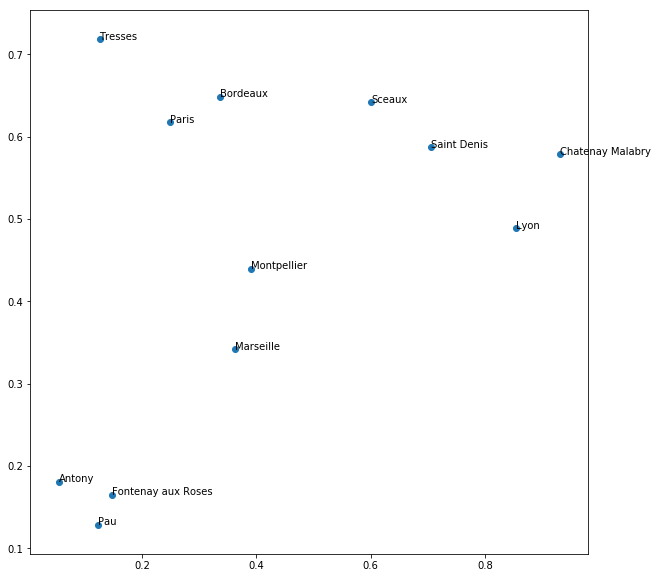

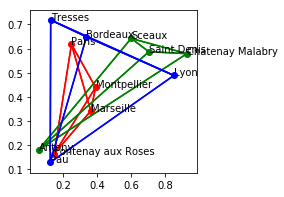

In [11]:
# test de mes fonctionnalités

coordinates, dist_matrix, pools = create_prob(city_count, pool_count)
plot_prob(coordinates, cities)

df = create_dist_df(cities, pools, coordinates)
update_pools_in_df(df, pools, dist_matrix )
plot_from_df(df)    

row_scoring(df)
print(df)
pool_score = pool_scoring(df, mean_coef=1., dist_coef=0., max_coef=0., std_coef=0.)
print(pool_score)

In [12]:
# je brutalise un peu ; mais en tentant quand même de faire un générateur un peu malin
def pool_generator(city_count, pool_count, current_city=0, current_pool_dict=None, cpt_debug=0):
    #d'abord, je prends l'hypothèse que mes pools sont toutes de la même taille
    # todo : gérer ce cas (pools pas toutes de la même taille)
    # todo : je pense que maintenir la taille de mes pools serait plus malin que de refaire len(current_pool_dict[i]) 
    # à chaque fois...
    if current_pool_dict == None: current_pool_dict = defaultdict(set)
    pool_size = city_count // pool_count
    if current_city >= city_count:
        yield(current_pool_dict)
    for i in range(min(len(current_pool_dict)+1, pool_count)):
        if len(current_pool_dict[i]) >= pool_size:
            continue
        temp_pool_dict = deepcopy(current_pool_dict)
        temp_pool_dict[i].add(current_city)
        yield from pool_generator(city_count, pool_count, current_city=current_city+1, current_pool_dict=temp_pool_dict, cpt_debug=cpt_debug+1)

1.8731089153613358
2.1122539967244305
2.2132794405757554
4.810357295206773
4.811299745600323
4.813076453259889


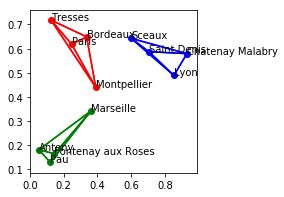

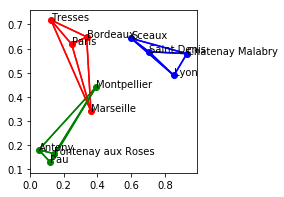

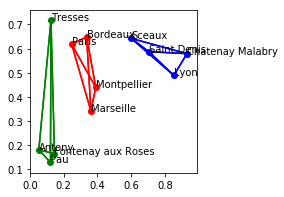

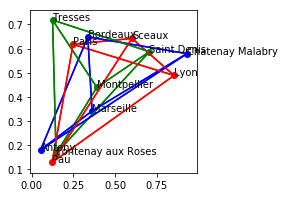

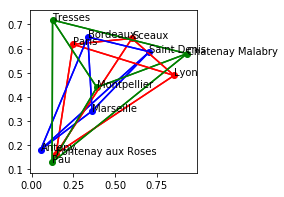

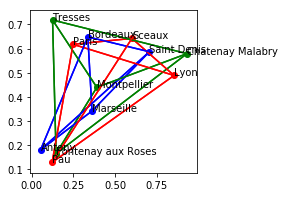

In [13]:
result_list = []

def solve_brutal(cities, pool_count, coordinates):
    pass

def solve(cities, pool_count, coordinates, solver='brutal'):
    if solver == 'brutal':
        return(solve_brutal(cities, pool_count, coordinates))

for pool in pool_generator(12,3):
    df = create_dist_df(cities, pool, coordinates)
    update_pools_in_df(df, pool, dist_matrix )
    #plot_from_df(df)    
    row_scoring(df)
    #pool_score = pool_scoring(df, mean_coef=1., dist_coef=0., max_coef=0., std_coef=0.)
    #print(final_scoring(df, mean_coef=1., dist_coef=0., max_coef=0., std_coef=0.))
    result_list.append( (final_scoring(df, mean_coef=1., dist_coef=0., max_coef=0., std_coef=0.), df.copy()) )

for result in sorted(result_list)[:3]:
    print(result[0])
    plot_from_df(result[1])
    
for result in sorted(result_list)[-3:]:
    print(result[0])
    plot_from_df(result[1])
